In [4]:
import distutils.spawn
from matplotlib import rc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import numpy as np

from models import FullResNet

In [5]:
sns.set(font_scale=1.5)

if distutils.spawn.find_executable('latex'):
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)

In [8]:
default_config= {
    'width': 40,
    'activation': 'ReLU',
    'regularity': {},
}

In [10]:
dim_input = 64
nb_classes = 1

niter = 5
n_init = 10
depth = 1000
grid_beta = list(np.linspace(0, 1.3, 70))
grid_reg = list(np.linspace(0.05, 0.97, 51))
results = []

for reg in grid_reg:
    print(reg)
    for k in range(niter):
        print(k)
        model_config = default_config
        model_config['scaling_beta'] = 0.5
        model_config['depth'] = depth
        model_config['regularity']['type'] = 'fbm'
        model_config['regularity']['value'] = reg
        model = FullResNet(dim_input, nb_classes, **model_config)
        
        for beta in grid_beta:
            model.reset_scaling(beta)
            
            for k in range(n_init):
        
                x0 = torch.rand((1, dim_input))
                target = torch.rand((1,))

                h_0 = model.init(x0)
                h_L = model.forward_hidden_state(h_0)
                output = model.final(h_L)

                h_0.retain_grad()
                h_L.retain_grad()

                loss = torch.norm(output-target)**2
                loss.backward()

                h_0_grad = h_0.grad
                h_L_grad = h_L.grad

                results.append({
                    'depth':depth, 
                    'beta': beta, 
                    'regularity': reg,
                    'hidden_state_difference': float(torch.norm(h_L - h_0) / torch.norm(h_0)),
                    'gradient_difference': float(torch.norm(h_L_grad - h_0_grad) / torch.norm(h_L_grad)),
                })

0.05
0
1
2
3
4
0.14200000000000002
0
1
2
3
4
0.23399999999999999
0
1
2
3
4
0.326
0
1
2
3
4
0.418
0
1
2
3
4
0.51
0
1
2
3
4
0.6020000000000001
0
1
2
3
4
0.6940000000000001
0
1
2
3
4
0.786
0
1
2
3
4
0.878
0
1
2
3
4
0.97
0
1
2
3
4


In [18]:
df = pd.DataFrame(results)

In [19]:
df.columns = ['depth', 'scaling', 'regularity', 'hidden_state_difference', 'gradient_difference']

In [20]:
df['log_hidden_state_difference'] = np.log10(df['hidden_state_difference'])
df['log_gradients_difference'] = np.log10(df['gradient_difference'])

In [21]:
df.to_csv('simulations/relationship-scaling-init.csv')

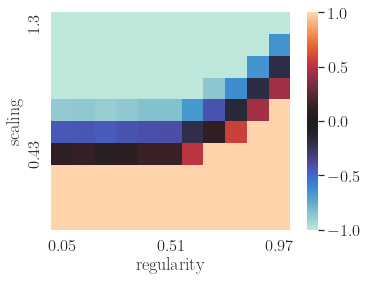

In [33]:
df2 = df.pivot_table(index='scaling', columns='regularity', values='log_hidden_state_difference', dropna=False)
df2.index = np.round(df2.index.astype(float), 2)
df2.columns = np.round(df2.columns.astype(float), 2)
df2 = df2.fillna(16)
sns.heatmap(df2[::-1], vmin=-1, vmax=1, center=0, xticklabels=5, yticklabels=6, square=True)
#plt.savefig('figures/heatmap-scaling-regularity.pdf', bbox_inches='tight')
plt.show()

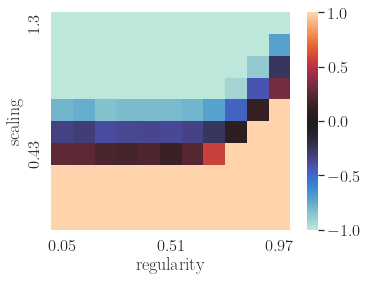

In [32]:
df2 = df.pivot_table(index='scaling', columns='regularity', values='log_gradients_difference', dropna=False)
df2.index = np.round(df2.index.astype(float), 2)
df2.columns = np.round(df2.columns.astype(float), 2)
df2 = df2.fillna(16)
sns.heatmap(df2[::-1], vmin=-1, vmax=1, center=0, xticklabels=5, yticklabels=6, square=True)
#plt.savefig('figures/heatmap-scaling-regularity.pdf', bbox_inches='tight')
plt.show()